# Локальный градиентный спуск

In [1]:
import numpy as np
from matplotlib import pyplot as plt

**Цель:** минимизировать значение функции $F(x) = \frac{1}{M}\sum_{i = 1}^{M} f_i (x)$.  
**Описание алгоритма:** локальный градиентный спуск, реализованный в файле main.py, принимает на вход следующие аргументы:  
1) N - количество эпох, т.е. количество коммуникаций между сервером и клиентами  
2) H - количество шагов градиентного спуска в каждой эпохе (частота коммуникаций)  
3) $x_0$ - начальная точка  
4) $\gamma$ - коэффициент при градиентном шаге  
5) M градиентов  
  
Алгоритм возвращает все точки, отправленные клиентам за всё время его работы.  

Заметим, что $\nabla f_i(x) = 2A_i x$, следовательно $L_i = 2 \cdot max\{\lambda_{i_j}\}$, где $\lambda_{i_j}$ - собственные числа $A_i$. Т.к. $A_i$ - диалгональные, то это просто есть максимум из чисел, стоящих на диагонали.  
Те же рассуждения работают для $F(x) = \frac{1}{M}\sum_{i = 1}^{M} f_i (x)$.

In [2]:
def array_to_str(arr):
    return 'np.array([' + ', '.join([str(q) for q in arr]) + '])'


DIM = 100

A1 = np.diag(np.random.randint(1, 10, DIM))
A2 = np.diag(np.random.randint(1, 10, DIM))
A3 = np.diag(np.random.randint(1, 10, DIM))

L = 2*np.max(np.diagonal(A1 + A2 + A3))/3
H = 10
epoch_num = 1000
x0 = np.random.randint(-100, 100, DIM)
gamma = 1/(4*L*H)
print('L  = ', round(L, 2), '\t gamma  = ', round(gamma, 4))

L  =  15.33 	 gamma  =  0.0016


In [3]:
grad1 = '2*np.diag(' + array_to_str(A1.diagonal()) + ')@x'
grad2 = '2*np.diag(' + array_to_str(A2.diagonal()) + ')@x'
grad3 = '2*np.diag(' + array_to_str(A3.diagonal()) + ')@x'
x0 = array_to_str(x0)

points = ! mpiexec -n 4 python main.py {epoch_num} {H} '{x0}' {gamma} '{grad1}' '{grad2}' '{grad3}'
points = np.array(eval(''.join(points)))

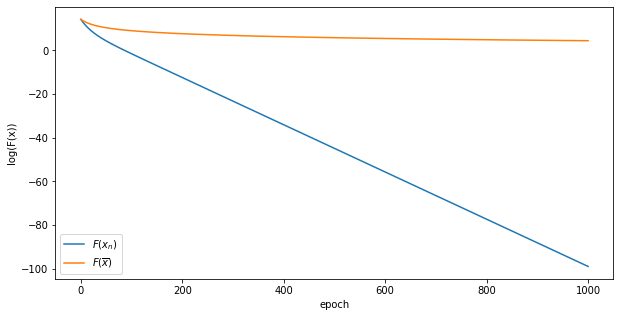

In [4]:
Y_1 = [(p.transpose()@A1@p + p.transpose()@A2@p + p.transpose()@A1@p)/3 for p in points]
mean_points = np.cumsum(points, axis=0) / np.arange(1, len(points) + 1)[:, None]
Y_2 = [(p.transpose()@A1@p + p.transpose()@A2@p + p.transpose()@A1@p)/3 for p in mean_points]
plt.figure(figsize=(10, 5))
plt.xlabel('epoch')
plt.ylabel('log(F(x))')
plt.plot(np.log(Y_1), label='$F(x_n)$')
plt.plot(np.log(Y_2), label='$F(\\overline{x})$')
plt.legend()

Как видим, значение функции со свистом уходит в ноль. С меньшим свистом, но в том же направлении двигается и значение в усредненной по всем эпохам точке.  
Попробуем теперь рассмотреть функции вида $f_i(x) = x^T A_i x - b^T x $. Оставим $A_i$ теми же.
Путем несложных вычислений, которые мы оставляем любознательному читателю в качестве упражнения, получим, что градиент   $F(x) = 2(A_1 + A_2 + A_3)x - b_1 - b_2 - b_3$  
Отсюда $x_* = \frac{1}{2} (A_1 + A_2 + A_3)^{-1}(b_1 + b_2 + b_3)$

In [5]:
b1 = np.random.randint(-100, 100, size=DIM)
b2 = np.random.randint(-100, 100, size=DIM)
b3 = np.random.randint(-100, 100, size=DIM)
x_min = np.linalg.inv(A1 + A2 + A3)@(b1 + b2 + b3)/2
F_min = (x_min.transpose()@A1@x_min + x_min.transpose()@A2@x_min + x_min.transpose()@A3@x_min - b1.transpose()@x_min - b2.transpose()@x_min - b3.transpose()@x_min)/3
print('F_min: ', F_min)

F_min:  -7367.824532602085


Заметим, что L осталось тем же. Посчитаем еще $\sigma_f^2 = \frac{1}{M}\sum \limits_{i = 1}^{M} \|\nabla f_i(x_*)\|^2$.

In [6]:
sigmf = (np.linalg.norm(2*A1@x_min - b1)**2 + np.linalg.norm(2*A2@x_min - b2)**2 + np.linalg.norm(2*A3@x_min - b3)**2)/3
print(sigmf)

272216.6474429663


Найдем $\frac{2\|x_0 - x_*\|^2}{T\gamma} + 24\gamma^2\sigma_f^2H^2L \approx 24\gamma^2\sigma_f^2H^2L$

In [7]:
err = 24*(gamma)**2 * sigmf * H**2 * L
print(err)

26629.88942376844


In [8]:
grad1 = '2*np.diag(' + array_to_str(A1.diagonal()) + ')@x - ' + array_to_str(b1) 
grad2 = '2*np.diag(' + array_to_str(A2.diagonal()) + ')@x - ' + array_to_str(b2)
grad3 = '2*np.diag(' + array_to_str(A3.diagonal()) + ')@x - ' + array_to_str(b3)

points = ! mpiexec -n 4 python main.py {epoch_num} {H} '{x0}' {gamma} '{grad1}' '{grad2}' '{grad3}'
points = np.array(eval(''.join(points)))

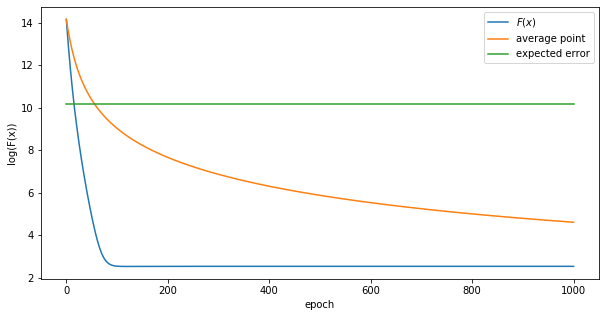

In [9]:
Y_1 = np.array([(p.transpose()@A1@p + p.transpose()@A2@p + p.transpose()@A3@p - b1.transpose()@p - b2.transpose()@p - b3.transpose()@p)/3 for p in points])
mean_points = np.cumsum(points, axis=0) / np.arange(1, len(points) + 1)[:, None]
Y_2 = np.array([(p.transpose()@A1@p + p.transpose()@A2@p + p.transpose()@A3@p - b1.transpose()@p - b2.transpose()@p - b3.transpose()@p)/3 for p in mean_points])
Y3 = np.array([F_min]*len(points))
plt.figure(figsize=(10, 5))
plt.xlabel('epoch')
plt.ylabel('log(F(x))')
plt.plot(np.log(Y_1 - Y3), label='$F(x)$')
plt.plot(np.log(Y_2 - Y3), label='average point')
plt.plot(np.log([err]*len(Y_1)), label='expected error')
plt.legend()

Хотя оптимальное значение и не было достигнуто, ошибка укладывается в рамки заявленной ошибки, что не может не радовать.  
Проделаем теперь те же манипуляции в случае, когда $f_i(x)$ просто выпуклы, не сильно.

In [10]:
A1 = np.random.randint(1, 10, DIM)
A2 = np.random.randint(1, 10, DIM)
A3 = np.random.randint(1, 10, DIM)
A1[0] = 0
A2[1] = 0
A3[2] = 0
A1 = np.diag(A1)
A2 = np.diag(A2)
A3 = np.diag(A3)

x_min = np.linalg.inv(A1 + A2 + A3)@(b1 + b2 + b3)/2
F_min = (x_min.transpose()@A1@x_min + x_min.transpose()@A2@x_min + x_min.transpose()@A3@x_min - b1.transpose()@x_min - b2.transpose()@x_min - b3.transpose()@x_min)/3
print('F_min: ', F_min)

F_min:  -6378.890563527122


In [11]:
grad1 = '2*np.diag(' + array_to_str(A1.diagonal()) + ')@x - ' + array_to_str(b1) 
grad2 = '2*np.diag(' + array_to_str(A2.diagonal()) + ')@x - ' + array_to_str(b2)
grad3 = '2*np.diag(' + array_to_str(A3.diagonal()) + ')@x - ' + array_to_str(b3)

points = ! mpiexec -n 4 python main.py {epoch_num} {H} '{x0}' {gamma} '{grad1}' '{grad2}' '{grad3}'
points = np.array(eval(''.join(points)))

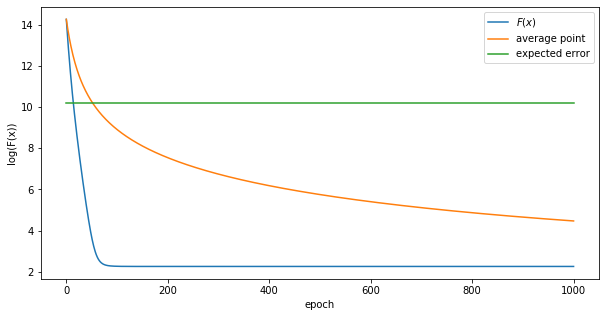

In [12]:
Y_1 = np.array([(p.transpose()@A1@p + p.transpose()@A2@p + p.transpose()@A3@p - b1.transpose()@p - b2.transpose()@p - b3.transpose()@p)/3 for p in points])
mean_points = np.cumsum(points, axis=0) / np.arange(1, len(points) + 1)[:, None]
Y_2 = np.array([(p.transpose()@A1@p + p.transpose()@A2@p + p.transpose()@A3@p - b1.transpose()@p - b2.transpose()@p - b3.transpose()@p)/3 for p in mean_points])
Y3 = np.array([F_min]*len(points))
plt.figure(figsize=(10, 5))
plt.xlabel('epoch')
plt.ylabel('log(F(x))')
plt.plot(np.log(Y_1 - Y3), label='$F(x)$')
plt.plot(np.log(Y_2 - Y3), label='average point')
plt.plot(np.log([err]*len(Y_1)), label='expected error')
plt.legend()

## (Тщетные) попытки усовершенствовать алгоритм  
Прежде всего напомним читателю, что отрицательный результат - тоже результат. Идея состоит в том, чтобы вместо возвращения всем клиентам усредненной точки возвращать что-то более интеллектуальное.  
Более конкретно: хотелолось бы возвращать такое $x = g(x_1, ..., x_n)$, где g - неизвестная нам пока функция, что $F(x) \rightarrow min$. В классическом градиентном спуске берется обычное среднее. Лучший ли это выбор в классе выпуклых линейных комбинаций? Как будет показано ниже - нет.  
Итак, пусть нам вернулись фиксированные $x_1, ..., x_m$. Введем функцию $\phi(\alpha) = F(\alpha_1x_1 + ... + \alpha_mx_m)$, $\alpha \in R^m$. Наша цель - решить задачу условной минимизации $\phi(\alpha)$ при условиях $\alpha_i \geq 0$ и $\sum \alpha_i = 1$.  
Не вдаваясь в подробности, приведем ответ. Решением этой задачи будет $\alpha_i = 0$ $\forall i \neq k$, $\alpha_k = 1$, где $k$ выбрано таким образом, что $\langle \sum_i \nabla f_i(x_k), x_k \rangle \rightarrow min$.  
Очевидно, пользоваться таким критерием выборка $x_k$ смысла нет, нам для этого нужно вычислить $m^2$ градиентов. Однако это демонстрирует нам, что лучшую точку следует искать среди $x_1, ..., x_m$. В связи с этим первая сумасшедшая идея - попробовать возвращать точку, случайным образом выбранную среди $x_1, ..., x_m$.

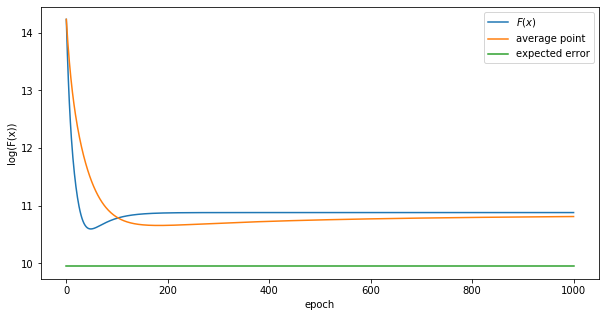

In [16]:
A1 = np.diag(np.random.randint(1, 10, DIM))
A2 = np.diag(np.random.randint(1, 10, DIM))
A3 = np.diag(np.random.randint(1, 10, DIM))

L = 2*np.max(np.diagonal(A1 + A2 + A3))/3
H = 10
epoch_num = 1000
x0 = np.random.randint(-100, 100, DIM)
x0 = array_to_str(x0)
gamma = 1/(4*L*H)

b1 = np.random.randint(-100, 100, size=DIM)
b2 = np.random.randint(-100, 100, size=DIM)
b3 = np.random.randint(-100, 100, size=DIM)
x_min = np.linalg.inv(A1 + A2 + A3)@(b1 + b2 + b3)/2
F_min = (x_min.transpose()@A1@x_min + x_min.transpose()@A2@x_min + x_min.transpose()@A3@x_min - b1.transpose()@x_min - b2.transpose()@x_min - b3.transpose()@x_min)/3
sigmf = (np.linalg.norm(2*A1@x_min - b1)**2 + np.linalg.norm(2*A2@x_min - b2)**2 + np.linalg.norm(2*A3@x_min - b3)**2)/3
err = 24*(gamma)**2 * sigmf * H**2 * L

grad1 = '2*np.diag(' + array_to_str(A1.diagonal()) + ')@x - ' + array_to_str(b1) 
grad2 = '2*np.diag(' + array_to_str(A2.diagonal()) + ')@x - ' + array_to_str(b2)
grad3 = '2*np.diag(' + array_to_str(A3.diagonal()) + ')@x - ' + array_to_str(b3)

points1 = ! mpiexec -n 4 python main1.py {epoch_num} {H} '{x0}' {gamma} '{grad1}' '{grad2}' '{grad3}'
points1 = np.array(eval(''.join(points1)))

Y_1 = np.array([(p.transpose()@A1@p + p.transpose()@A2@p + p.transpose()@A3@p - b1.transpose()@p - b2.transpose()@p - b3.transpose()@p)/3 for p in points1])
mean_points = np.cumsum(points1, axis=0) / np.arange(1, len(points1) + 1)[:, None]
Y_2 = np.array([(p.transpose()@A1@p + p.transpose()@A2@p + p.transpose()@A3@p - b1.transpose()@p - b2.transpose()@p - b3.transpose()@p)/3 for p in mean_points])
Y3 = np.array([F_min]*len(Y_1))
plt.figure(figsize=(10, 5))
plt.xlabel('epoch')
plt.ylabel('log(F(x))')
plt.plot(np.log(Y_1 - Y3), label='$F(x)$')
plt.plot(np.log(Y_2 - Y3), label='average point')
plt.plot(np.log([err]*len(Y_1)), label='expected error')
plt.legend()

Совсем всё плохо.  
Попробуем применить другое правило. Напомним, мы хотим найти такое $x_k$, что $\langle \sum_i \nabla f_i(x_k), x_k \rangle \rightarrow min$. При этом мы не хотим считать никаких $\nabla f_i(x_j)$ при $i \neq j$. Самый тупой способ сделать это - выкинуть такие штуки подальше и искать минимум $\langle \nabla f_k(x_k), x_k \rangle$. Что и проделано ниже.

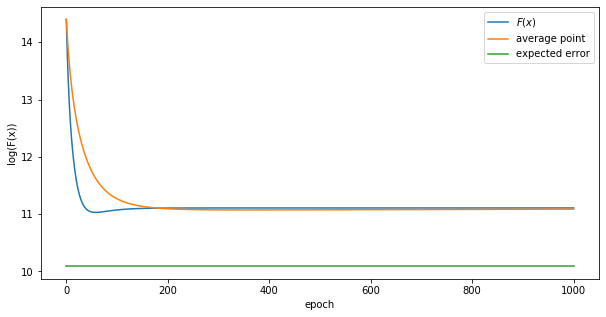

In [14]:
points2 = ! mpiexec -n 4 python main2.py {epoch_num} {H} '{x0}' {gamma} '{grad1}' '{grad2}' '{grad3}'
points2 = np.array(eval(''.join(points2)))

Y_11 = np.array([(p.transpose()@A1@p + p.transpose()@A2@p + p.transpose()@A3@p - b1.transpose()@p - b2.transpose()@p - b3.transpose()@p)/3 for p in points2])
mean_points = np.cumsum(points2, axis=0) / np.arange(1, len(points2) + 1)[:, None]
Y_22 = np.array([(p.transpose()@A1@p + p.transpose()@A2@p + p.transpose()@A3@p - b1.transpose()@p - b2.transpose()@p - b3.transpose()@p)/3 for p in mean_points])
Y3 = np.array([F_min]*len(Y_11))
plt.figure(figsize=(10, 5))
plt.xlabel('epoch')
plt.ylabel('log(F(x))')
plt.plot(np.log(Y_11 - Y3), label='$F(x)$')
plt.plot(np.log(Y_22 - Y3), label='average point')
plt.plot(np.log([err]*len(Y_11)), label='expected error')
plt.legend()

Еще хуже.  
Что ж, отрицательный результат есть тоже результат, а факт остается фактом - во мн-ве точек $x_1, ..., x_m$ есть точка, которая ближе к минимуму, чем $\overline{x}$. Вопрос лишь в том, существуют ли какие-то аппроксимации, позволяющие нам с хорошей вероятностью ее находить, не считая при этом $m^2$ градиентов.
## Рандомизация  
Сделаем тепеперь так, что каждый клиент за одну эпоху выполняет число итераций, лежащее в диапазоне $[H_{min}, H_{max}]$, конкретное число итераций выбирается из равномерного распределения в начале очередной эпохи каждым клиентом независмо от остальных. Для конкретики возьмем $H_{max} = 2H_{min}$. 

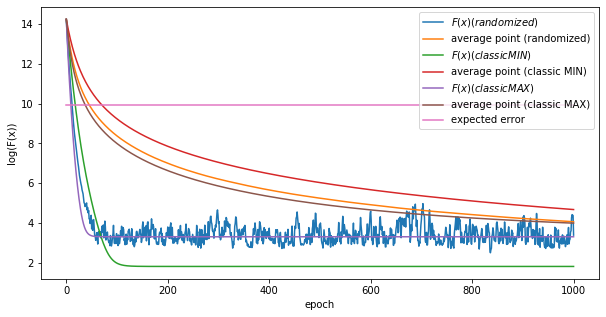

In [17]:
points = ! mpiexec -n 4 python main3.py {epoch_num} {H} {2*H} '{x0}' {gamma} '{grad1}' '{grad2}' '{grad3}'
points = np.array(eval(''.join(points)))
points0 = ! mpiexec -n 4 python main.py {epoch_num} {H} '{x0}' {gamma} '{grad1}' '{grad2}' '{grad3}'
points0 = np.array(eval(''.join(points0)))
points1 = ! mpiexec -n 4 python main.py {epoch_num} {2*H} '{x0}' {gamma} '{grad1}' '{grad2}' '{grad3}'
points1 = np.array(eval(''.join(points1)))

Y_1 = np.array([(p.transpose()@A1@p + p.transpose()@A2@p + p.transpose()@A3@p - b1.transpose()@p - b2.transpose()@p - b3.transpose()@p)/3 for p in points])
mean_points = np.cumsum(points, axis=0) / np.arange(1, len(points) + 1)[:, None]
Y_2 = np.array([(p.transpose()@A1@p + p.transpose()@A2@p + p.transpose()@A3@p - b1.transpose()@p - b2.transpose()@p - b3.transpose()@p)/3 for p in mean_points])
Z_1 = np.array([(p.transpose()@A1@p + p.transpose()@A2@p + p.transpose()@A3@p - b1.transpose()@p - b2.transpose()@p - b3.transpose()@p)/3 for p in points0])
mean_points = np.cumsum(points0, axis=0) / np.arange(1, len(points0) + 1)[:, None]
Z_2 = np.array([(p.transpose()@A1@p + p.transpose()@A2@p + p.transpose()@A3@p - b1.transpose()@p - b2.transpose()@p - b3.transpose()@p)/3 for p in mean_points])
Q_1 = np.array([(p.transpose()@A1@p + p.transpose()@A2@p + p.transpose()@A3@p - b1.transpose()@p - b2.transpose()@p - b3.transpose()@p)/3 for p in points1])
mean_points = np.cumsum(points1, axis=0) / np.arange(1, len(points1) + 1)[:, None]
Q_2 = np.array([(p.transpose()@A1@p + p.transpose()@A2@p + p.transpose()@A3@p - b1.transpose()@p - b2.transpose()@p - b3.transpose()@p)/3 for p in mean_points])
Y3 = np.array([F_min]*max(len(points), len(points0)))

plt.figure(figsize=(10, 5))
plt.xlabel('epoch')
plt.ylabel('log(F(x))')
plt.plot(np.log(Y_1 - Y3), label='$F(x) (randomized)$')
plt.plot(np.log(Y_2 - Y3), label='average point (randomized)')
plt.plot(np.log(Z_1 - Y3), label='$F(x) (classic MIN)$')
plt.plot(np.log(Z_2 - Y3), label='average point (classic MIN)')
plt.plot(np.log(Q_1 - Y3), label='$F(x) (classic MAX)$')
plt.plot(np.log(Q_2 - Y3), label='average point (classic MAX)')
plt.plot(np.log([err]*len(Y_1)), label='expected error')
plt.legend()

Ничего хорошего. Скорость сходимости по средней точке зажата так же между скоростями классического метода при $H_{min}$ и $H_{max}$.